In [317]:
import sys, os 
import numpy as np 
import pandas as pd
from src import utils, plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import rcParams
default_font = 12
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange'] #rew #nrew #rew_test #nrew_test #GI

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [318]:
def filter_neurons(m, area, category, celltype=None):
        """ 
        This function filters the neurons based on the area, category and celltype

        Parameters:
        m (object): a mouse data object
        area (str): the area of the brain to filter the neurons
        category (str): the category of the stimuli to filter the neurons
        celltype (str): the celltype to filter the neurons

        Returns:
        selection (np.array): a boolean array with the neurons that meet the criteria
        """

        try:
            ia = utils.get_region_idx(m.iarea, area)
        except:
            AssertionError("area must be 'V1', 'medial', 'lateral' or 'anterior'")
        if celltype is not None:
            if celltype == "Pyr":
                selected_type = np.logical_not(m.isred[:,0]).astype(bool)
            elif celltype == "Int":
                selected_type = m.isred[:,0].astype(bool)
            else:
                AssertionError("celltype must be 'Pyr' or 'Int' or None")
            if category == "A":
                dp = m.train_dp >= np.percentile(m.train_dp[ia*selected_type], 95)
            elif category == "B":
                dp = m.train_dp <= np.percentile(m.train_dp[ia*selected_type], 5)
            else:
                AssertionError("category must be A or B")
            selection = ia * dp * selected_type
            prop = selection.sum() / ia.sum()
        else:
            if category == "A":
                dp = m.train_dp >= np.percentile(m.train_dp[ia], 95)
            elif category == "B":
                dp = m.train_dp <= np.percentile(m.train_dp[ia], 5)
            else:
                AssertionError("category must be A or B")
            selection = ia * dp
            prop = selection.sum() / ia.sum()
        return selection, prop

Lets get the optimal performance sessions for the category learning task:

In [319]:
VG11 = []
VG11.append({'mname': 'VG11', 'datexp': '2024_10_31', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_14', 'blk':'2'})
VG14 = []
VG14.append({'mname': 'VG14', 'datexp': '2024_11_21', 'blk':'2'})
VG15 = []
VG15.append({'mname': 'VG15', 'datexp': '2024_10_31', 'blk':'2'})
all_sessions = VG11 + VG14 + VG15
all_sessions

[{'mname': 'VG11', 'datexp': '2024_10_31', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_14', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_11_21', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_10_31', 'blk': '2'}]

I develop the code for one mouse first, it everything seems good, given the object structure arragement I can simply loop over all mice:

In [320]:
for sess in all_sessions[:1]:
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path="D:\mouseobj")

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])


This have a practical/easy solution what I will do is:
1. Get the lick dataframe
2. Remove the initial entry per trial (flag = 1) means is not a lick is just the beggining of the trial
3. Get the first lick per trial
4. Filter for trials in which the first lick was after 50 cm and before 250 cm (effective contrast portion of the trial)
5. add a column that colapses the 4 trial subtypes into the two categories

In [333]:
licks_df = utils.get_lick_df(m)
ntrials = licks_df['trial'].nunique()
licks_df = licks_df.query('flag == 0')
first_lick = licks_df.groupby('trial').first().reset_index()
first_lick = first_lick.query("distance >= 50 & distance < 250")
first_lick = first_lick.reset_index(drop=True)
first_lick = first_lick.assign(category = first_lick["trial_type"].map({"rewarded": "A", "non rewarded": "B", "rewarded test": "A", "non rewarded test": "B"}))
first_lick

,trial,distance,flag,is_test,date,hour_min_sec,seconds_in_session,trial_type,category
0,2.0,76.00,0.0,7.600,2024-10-31,14:32:36.265997,9.616001,non rewarded test,B
1,3.0,89.30,0.0,8.930,2024-10-31,14:32:44.687003,18.037007,rewarded,A
2,7.0,98.80,0.0,9.880,2024-10-31,14:33:22.049997,55.400001,rewarded,A
3,10.0,85.50,0.0,8.550,2024-10-31,14:33:53.611996,86.962000,rewarded test,A
4,13.0,71.25,0.0,7.125,2024-10-31,14:34:19.340000,112.690004,rewarded,A
...,...,...,...,...,...,...,...,...,...
119,241.0,210.90,0.0,21.090,2024-10-31,15:31:42.226003,3555.576007,rewarded test,A
120,243.0,165.30,0.0,16.530,2024-10-31,15:32:09.299996,3582.650000,non rewarded test,B
121,246.0,81.70,0.0,8.170,2024-10-31,15:32:36.775999,3610.126003,rewarded test,A
122,249.0,160.55,0.0,16.055,2024-10-31,15:33:06.163005,3639.513009,rewarded,A


<AxesSubplot:xlabel='distance', ylabel='Count'>

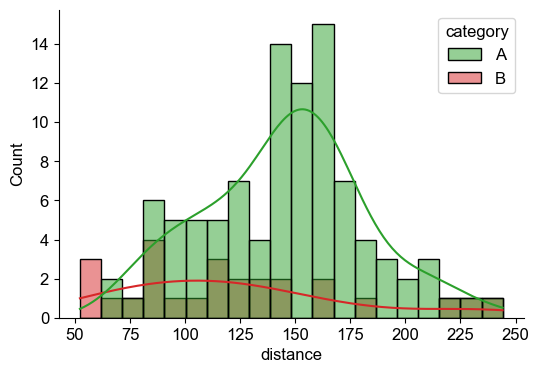

In [334]:
# plot the histogram of distances per categories
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(first_lick, x='distance', hue='category', bins=20, kde=True, palette=trial_type_palette[:2], ax=ax, hue_order=['A', 'B'])

<AxesSubplot:xlabel='distance', ylabel='Count'>

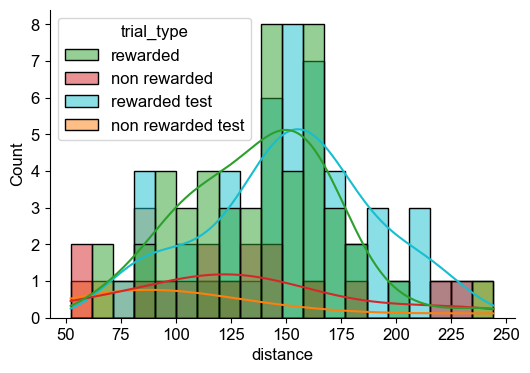

In [335]:
# plot the histogram of distances per categories
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(first_lick, x='distance', hue='trial_type', bins=20, kde=True, palette=trial_type_palette, ax=ax, hue_order=['rewarded', 'non rewarded', 'rewarded test', 'non rewarded test'])

Then lets get all the trials for each category:

In [336]:
A_trials = np.concatenate([m.trial_dict['rewarded'][1::2], m.trial_dict['rewarded test']])
B_trials = np.concatenate([m.trial_dict['non rewarded'][1::2], m.trial_dict['non rewarded test']])

In [337]:
from scipy.stats import sem

this piece of code collects the first lick centered response for each trial for all the trials that meet the criteria of the first lick being between 50 and 300 cm


In [338]:
vals = first_lick[['trial', 'distance', 'category']].copy()
nareas = len(['V1', 'medial', 'lateral', 'anterior'])
ncats = len(['A', 'B'])
ncelltypes = len(['Pyr', 'Int'])
centered_licks = np.ones((nareas, ncelltypes, ncats, ntrials, 200)) * np.nan
for ia, area in enumerate(['V1', 'medial', 'lateral', 'anterior']):
    for ictype, ctype in enumerate(['Pyr', 'Int']):
        for icat, cat in enumerate(['A', 'B']):
            selection, prop = filter_neurons(m, area, cat, ctype)
            avg_response = m.interp_spks[selection].mean(axis=0)
            for trial, lick_pos, cat in vals.values:
                trial = int(trial) - 1
                lick_pos = int(np.ceil(lick_pos))
                ranges = (lick_pos-100, lick_pos+100)
                if ranges[0] < 0 & trial==0:
                    continue
                elif ranges[0] < 0:
                    prior_segment = avg_response[trial-1, ranges[0]:]
                    avg_r = np.concatenate([prior_segment, avg_response[trial, :ranges[1]]])
                else:
                    avg_r = avg_response[trial, ranges[0]:ranges[1]]
                centered_licks[ia, ictype, icat, trial,:] = avg_r
centered_licks.shape

(4, 2, 2, 254, 200)

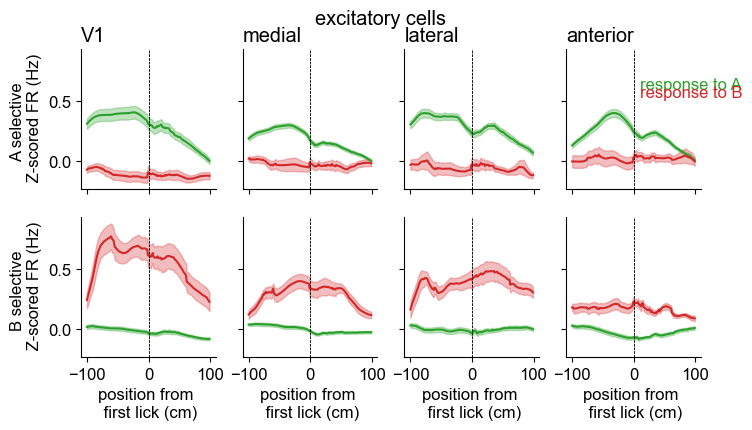

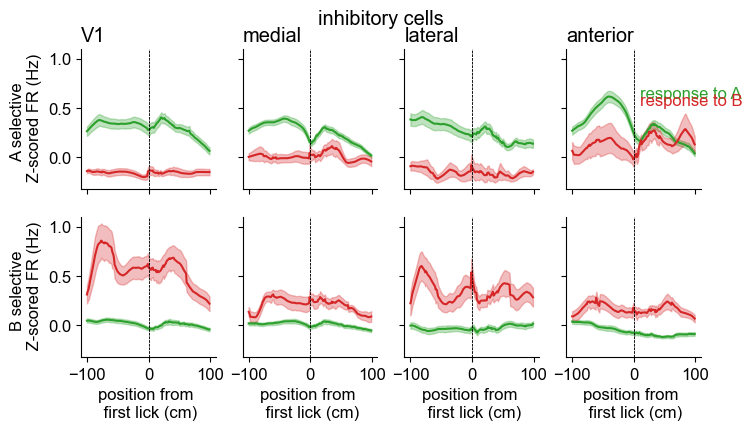

In [339]:
centered_x = np.arange(-100, 100)
for ictype, ctype in enumerate(['Pyr', 'Int']):
    fig, ax = plt.subplots(2, 4, figsize=(8, 4), sharey=True, sharex=True)
    if ictype == 0:
        fig.suptitle('excitatory cells', y=0.98)
    else:
        fig.suptitle('inhibitory cells', y=0.98)
    ax[0,3].text(10, .6, 'response to A', color='tab:green')
    ax[0,3].text(10, .53, 'response to B', color='tab:red')
    for ia, area in enumerate(['V1', 'medial', 'lateral', 'anterior']):
        ax[0, ia].set_title(f'{area}')
        ax[1, ia].set_xlabel('position from \n first lick (cm)')
        for icat, cat in enumerate(['A', 'B']):
            ax[icat, 0].set_ylabel(f'{cat} selective \n Z-scored FR (Hz)')
            for it, ttype in enumerate([A_trials, B_trials]):
                avg_r = np.nanmean(centered_licks[ia, ictype, icat, ttype], axis=0)
                sem_r = sem(centered_licks[ia, ictype, icat, ttype], axis=0, nan_policy='omit')
                if it == 0:
                    ax[icat,ia].plot(centered_x, avg_r, color='tab:green', label=cat)
                    ax[icat,ia].fill_between(centered_x, avg_r-sem_r, avg_r+sem_r, color='tab:green', alpha=0.3)
                else:
                    ax[icat,ia].plot(centered_x, avg_r, color='tab:red', label=cat)
                    ax[icat,ia].fill_between(centered_x, avg_r-sem_r, avg_r+sem_r, color='tab:red', alpha=0.3)
                ax[icat,ia].axvline(0, color='k', linestyle='--', linewidth=0.5)
                


We get the output we desire, now we can package the code and loop over all sessions:

In [341]:
def get_first_lick_df(m, position=(50, 300)):
    """ 
    this function returns the trials in which the first lick was inside the position range

    Parameters:
    m (object): a mouse data object
    position (tuple): the range of the position to filter the trials

    Returns:
    first_lick (pd.DataFrame): a dataframe with the trials in which the first lick was inside the position range
    """
    licks_df = utils.get_lick_df(m)
    licks_df = licks_df.query('flag == 0')
    first_lick = licks_df.groupby('trial').first().reset_index()
    first_lick = first_lick.query(f"distance >= {position[0]} & distance < {position[1]}")
    first_lick = first_lick.reset_index(drop=True)
    first_lick = first_lick.assign(category = first_lick["trial_type"].map({"rewarded": "A", "non rewarded": "B", "rewarded test": "A", "non rewarded test": "B"}))
    return first_lick

def get_centered_lick_response(m, first_lick):

    """ 
    this function returns the centered lick response for each trial, celltype, category and area, if the trial is not contained in first_lick df, the response is set to nan

    Parameters:
    m (object): a mouse data object
    first_lick (pd.DataFrame): a dataframe with the trials in which the first lick was inside the position range

    Returns:
    centered_licks (np.array): a 5D array with the centered lick response for each trial, celltype, category and area
    """
    ntrials = m.interp_spks.shape[1] 
    vals = first_lick[['trial', 'distance', 'category']].copy()
    nareas = len(['V1', 'medial', 'lateral', 'anterior'])
    ncats = len(['A', 'B'])
    ncelltypes = len(['Pyr', 'Int'])
    centered_licks = np.ones((nareas, ncelltypes, ncats, ntrials, 200)) * np.nan
    for ia, area in enumerate(['V1', 'medial', 'lateral', 'anterior']):
        for ictype, ctype in enumerate(['Pyr', 'Int']):
            for icat, cat in enumerate(['A', 'B']):
                selection, _ = filter_neurons(m, area, cat, ctype)
                avg_response = m.interp_spks[selection].mean(axis=0)
                for trial, lick_pos, cat in vals.values:
                    trial = int(trial) - 1
                    lick_pos = int(np.ceil(lick_pos))
                    ranges = (lick_pos-100, lick_pos+100)
                    if ranges[0] < 0 & trial==0:
                        continue
                    elif ranges[0] < 0:
                        prior_segment = avg_response[trial-1, ranges[0]:]
                        avg_r = np.concatenate([prior_segment, avg_response[trial, :ranges[1]]])
                    else:
                        avg_r = avg_response[trial, ranges[0]:ranges[1]]
                    centered_licks[ia, ictype, icat, trial,:] = avg_r
    print(centered_licks.shape, "(nareas, ncelltypes, ncat, ntrials, positions)")
    return centered_licks


# Lets go a collect the centered response for each animal:

1. Dprime neurons on the (0, 125) cm range of the corridor
2. Only using trials where the first lick happened between 50 and 250 cm with a range of 100 cm
    * That means that in the extreme cases if the first lick happened between 50 and 99 we will pad the gray intertrial period of the previous trial 
3. Using only test trials for the dprime neurons odd trials and all the "test" trials 

This gives us a centered response with symmetric ranges and licks happening when some contrast is on the monitor (excluding trivial licks)

In [343]:
nsess = len(all_sessions)
nareas = len(['V1', 'medial', 'lateral', 'anterior'])
ncats = len(['A', 'B'])
ncelltypes = len(['Pyr', 'Int'])
overall_centered_lick_resp = np.empty((nsess, nareas, ncelltypes, ncats, ncats, 200)) # avg per mouse, area, celltype, category selective, category response to, position
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path="D:\mouseobj")
    utils.compute_dprime(m, discrimination_region=(0,125), corridor_length=400) # using the 0-125 region to compute dprime
    first_lick = get_first_lick_df(m, position=(50, 250))
    A_trials = np.concatenate([m.trial_dict['rewarded'][1::2], m.trial_dict['rewarded test']]) # only odd trials (even are used for the dp)
    B_trials = np.concatenate([m.trial_dict['non rewarded'][1::2], m.trial_dict['non rewarded test']])
    trials_per_cat = np.array([A_trials, B_trials], dtype=object) # since the number of trials per category might be different we store them as an object
    centered_lick_response = get_centered_lick_response(m, first_lick)
    for irespto, trials in enumerate(trials_per_cat):
        trials = trials.astype(int)
        overall_centered_lick_resp[iss,:,:,:,irespto] = np.nanmean(centered_lick_response[:,:,:,trials,:], axis = 3) # avg over trials of each category
    np.save(f"../data/{name}/{date}/{blk}/centered_licks.npy", centered_lick_response) # save the centered lick response per session (just as sanity check)
    np.save(f"../data/{name}/{date}/{blk}/trials_per_cat.npy", trials_per_cat) # save the trials per category per session (useful later for plotting)
np.save(f"../data/overall/overall_centered_licks.npy", overall_centered_lick_resp) # save the centered lick response for all sessions

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
dprime saved in MouseObject.train_dp (neurons) using even trials
(4, 2, 2, 254, 200) (nareas, ncelltypes, ncat, ntrials, positions)
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
dpri

In [344]:
print(overall_centered_lick_resp.shape, "(nsess/mice, nareas, ncelltypes, cat selective, cat response, positions)")


(4, 4, 2, 2, 2, 200) (nsess/mice, nareas, ncelltypes, cat selective, cat response, positions)


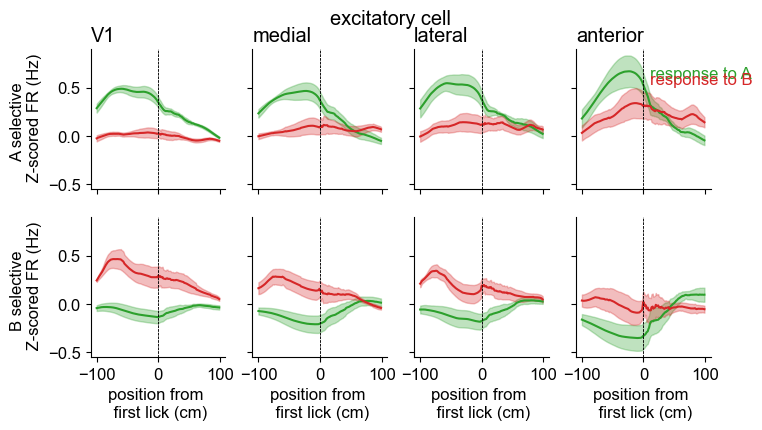

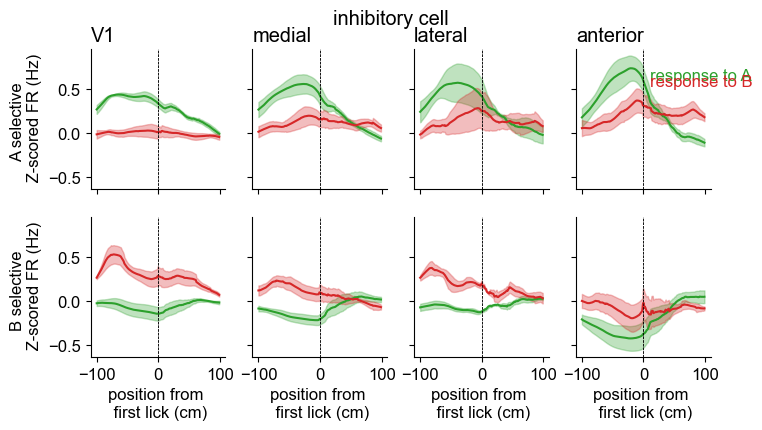

In [345]:
centered_x = np.arange(-100, 100)
avg_r_across_mice = np.nanmean(overall_centered_lick_resp, axis=0)
sem_r_across_mice = sem(overall_centered_lick_resp, axis=0, nan_policy='omit')
for ictype, ctype in enumerate(['Pyr', 'Int']):
    fig, ax = plt.subplots(2, 4, figsize=(8, 4), sharey=True, sharex=True)
    if ictype == 0:
        fig.suptitle('excitatory cell', y=0.98)
    else:
        fig.suptitle('inhibitory cell', y=0.98)
    ax[0,3].text(10, .6, 'response to A', color='tab:green')
    ax[0,3].text(10, .53, 'response to B', color='tab:red')
    for ia, area in enumerate(['V1', 'medial', 'lateral', 'anterior']):
        ax[0, ia].set_title(f'{area}')
        ax[1, ia].set_xlabel('position from \n first lick (cm)')
        for icat, cat in enumerate(['A', 'B']):
            ax[icat, 0].set_ylabel(f'{cat} selective \n Z-scored FR (Hz)')
            for it, ttype in enumerate(['A', 'B']):
                avg_r = avg_r_across_mice[ia, ictype, icat, it]
                sem_r = sem_r_across_mice[ia, ictype, icat, it]
                if it == 0:
                    ax[icat,ia].plot(centered_x, avg_r, color='tab:green', label=cat)
                    ax[icat,ia].fill_between(centered_x, avg_r-sem_r, avg_r+sem_r, color='tab:green', alpha=0.3)
                else:
                    ax[icat,ia].plot(centered_x, avg_r, color='tab:red', label=cat)
                    ax[icat,ia].fill_between(centered_x, avg_r-sem_r, avg_r+sem_r, color='tab:red', alpha=0.3)
                ax[icat,ia].axvline(0, color='k', linestyle='--', linewidth=0.5)

### Coding direction visualization

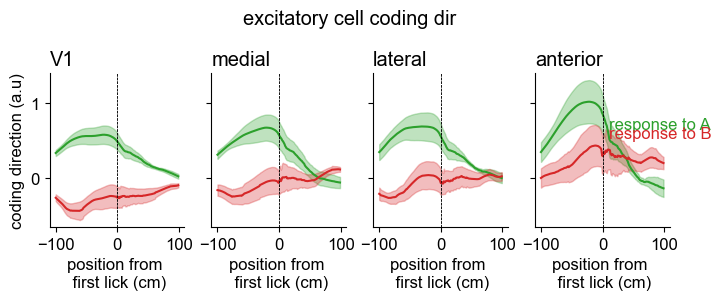

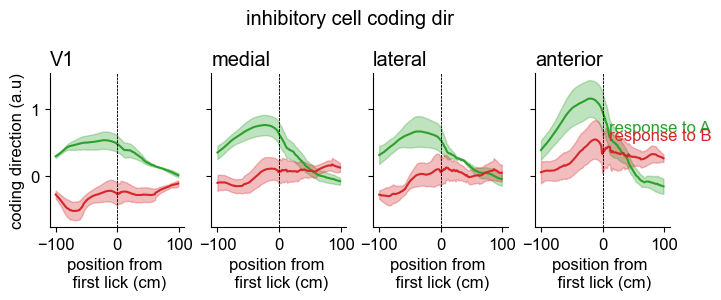

In [346]:
centered_x = np.arange(-100, 100)
cd = overall_centered_lick_resp[:,:,:,0] - overall_centered_lick_resp[:,:,:,1]
avg_r_across_mice = np.nanmean(cd, axis=0)
sem_r_across_mice = sem(cd, axis=0, nan_policy='omit')
for ictype, ctype in enumerate(['Pyr', 'Int']):
    fig, ax = plt.subplots(1, 4, figsize=(8, 2), sharey=True, sharex=True)
    if ictype == 0:
        fig.suptitle('excitatory cell coding dir', y=1.2)
    else:
        fig.suptitle('inhibitory cell coding dir', y=1.2)
    ax[3].text(10, .65, 'response to A', color='tab:green')
    ax[3].text(10, .53, 'response to B', color='tab:red')
    for ia, area in enumerate(['V1', 'medial', 'lateral', 'anterior']):
        ax[ia].set_title(f'{area}')
        ax[ia].set_xlabel('position from \n first lick (cm)')
        for it, ttype in enumerate(['A', 'B']):
            avg_r = avg_r_across_mice[ia, ictype, it]
            sem_r = sem_r_across_mice[ia, ictype, it]
            if it == 0:
                ax[ia].plot(centered_x, avg_r, color='tab:green', label=cat)
                ax[ia].fill_between(centered_x, avg_r-sem_r, avg_r+sem_r, color='tab:green', alpha=0.3)
            else:
                ax[ia].plot(centered_x, avg_r, color='tab:red', label=cat)
                ax[ia].fill_between(centered_x, avg_r-sem_r, avg_r+sem_r, color='tab:red', alpha=0.3)
            ax[ia].axvline(0, color='k', linestyle='--', linewidth=0.5)
    ax[0].set_ylabel(f'coding direction (a.u)')

# now lets grab neurons based on dprime on the reward region and compare between first lick position trials:

### dprime (150,250) and first lick between 50-250 cm

In [347]:
nsess = len(all_sessions)
nareas = len(['V1', 'medial', 'lateral', 'anterior'])
ncats = len(['A', 'B'])
ncelltypes = len(['Pyr', 'Int'])
overall_centered_lick_resp = np.empty((nsess, nareas, ncelltypes, ncats, ncats, 200)) # avg per mouse, area, celltype, category selective, category response to, position
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path="D:\mouseobj")
    utils.compute_dprime(m, discrimination_region=(150,250), corridor_length=400) # using the 0-125 region to compute dprime
    first_lick = get_first_lick_df(m, position=(50, 250))
    A_trials = np.concatenate([m.trial_dict['rewarded'][1::2], m.trial_dict['rewarded test']])
    B_trials = np.concatenate([m.trial_dict['non rewarded'][1::2], m.trial_dict['non rewarded test']])
    trials_per_cat = np.array([A_trials, B_trials], dtype=object) # since the number of trials per category might be different we store them as an object
    centered_lick_response = get_centered_lick_response(m, first_lick)
    for irespto, trials in enumerate(trials_per_cat):
        trials = trials.astype(int)
        overall_centered_lick_resp[iss,:,:,:,irespto] = np.nanmean(centered_lick_response[:,:,:,trials,:], axis = 3) # avg over trials of each category

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
dprime saved in MouseObject.train_dp (neurons) using even trials
(4, 2, 2, 254, 200) (nareas, ncelltypes, ncat, ntrials, positions)
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
dpri

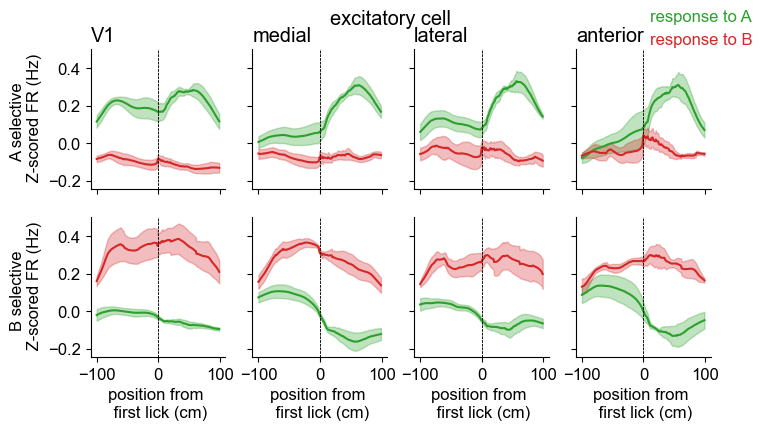

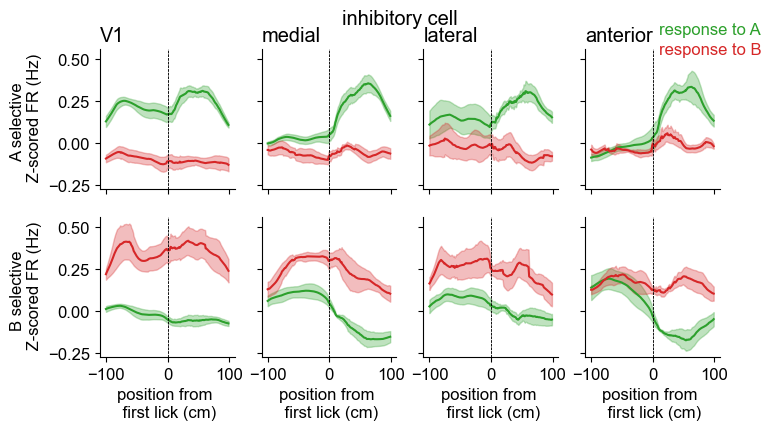

In [348]:
centered_x = np.arange(-100, 100)
avg_r_across_mice = np.nanmean(overall_centered_lick_resp, axis=0)
sem_r_across_mice = sem(overall_centered_lick_resp, axis=0, nan_policy='omit')
for ictype, ctype in enumerate(['Pyr', 'Int']):
    fig, ax = plt.subplots(2, 4, figsize=(8, 4), sharey=True, sharex=True)
    if ictype == 0:
        fig.suptitle('excitatory cell', y=0.98)
    else:
        fig.suptitle('inhibitory cell', y=0.98)
    ax[0,3].text(10, .65, 'response to A', color='tab:green')
    ax[0,3].text(10, .53, 'response to B', color='tab:red')
    for ia, area in enumerate(['V1', 'medial', 'lateral', 'anterior']):
        ax[0, ia].set_title(f'{area}')
        ax[1, ia].set_xlabel('position from \n first lick (cm)')
        for icat, cat in enumerate(['A', 'B']):
            ax[icat, 0].set_ylabel(f'{cat} selective \n Z-scored FR (Hz)')
            for it, ttype in enumerate(['A', 'B']):
                avg_r = avg_r_across_mice[ia, ictype, icat, it]
                sem_r = sem_r_across_mice[ia, ictype, icat, it]
                if it == 0:
                    ax[icat,ia].plot(centered_x, avg_r, color='tab:green', label=cat)
                    ax[icat,ia].fill_between(centered_x, avg_r-sem_r, avg_r+sem_r, color='tab:green', alpha=0.3)
                else:
                    ax[icat,ia].plot(centered_x, avg_r, color='tab:red', label=cat)
                    ax[icat,ia].fill_between(centered_x, avg_r-sem_r, avg_r+sem_r, color='tab:red', alpha=0.3)
                ax[icat,ia].axvline(0, color='k', linestyle='--', linewidth=0.5)

# we can also visualize it as the coding direction

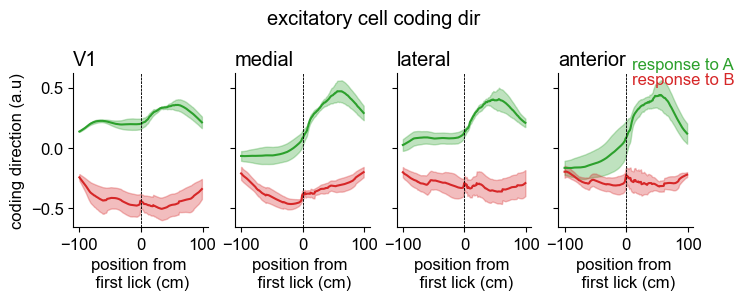

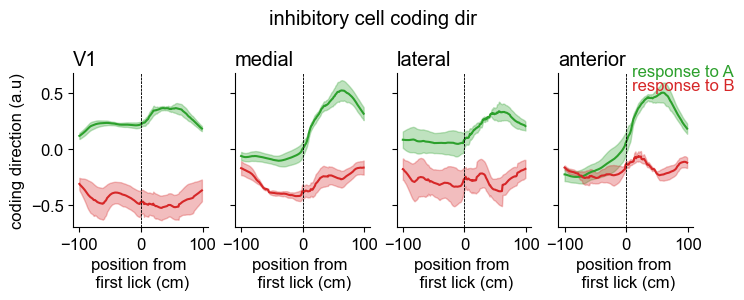

In [349]:
centered_x = np.arange(-100, 100)
cd = overall_centered_lick_resp[:,:,:,0] - overall_centered_lick_resp[:,:,:,1]
avg_r_across_mice = np.nanmean(cd, axis=0)
sem_r_across_mice = sem(cd, axis=0, nan_policy='omit')
for ictype, ctype in enumerate(['Pyr', 'Int']):
    fig, ax = plt.subplots(1, 4, figsize=(8, 2), sharey=True, sharex=True)
    if ictype == 0:
        fig.suptitle('excitatory cell coding dir', y=1.2)
    else:
        fig.suptitle('inhibitory cell coding dir', y=1.2)
    ax[3].text(10, .65, 'response to A', color='tab:green')
    ax[3].text(10, .53, 'response to B', color='tab:red')
    for ia, area in enumerate(['V1', 'medial', 'lateral', 'anterior']):
        ax[ia].set_title(f'{area}')
        ax[ia].set_xlabel('position from \n first lick (cm)')
        for it, ttype in enumerate(['A', 'B']):
            avg_r = avg_r_across_mice[ia, ictype, it]
            sem_r = sem_r_across_mice[ia, ictype, it]
            if it == 0:
                ax[ia].plot(centered_x, avg_r, color='tab:green', label=cat)
                ax[ia].fill_between(centered_x, avg_r-sem_r, avg_r+sem_r, color='tab:green', alpha=0.3)
            else:
                ax[ia].plot(centered_x, avg_r, color='tab:red', label=cat)
                ax[ia].fill_between(centered_x, avg_r-sem_r, avg_r+sem_r, color='tab:red', alpha=0.3)
            ax[ia].axvline(0, color='k', linestyle='--', linewidth=0.5)
    ax[0].set_ylabel(f'coding direction (a.u)')

## Conclusions

1) This shows that selecting neurons based on dprime (0,125) picks neurons that ara able to separate the category identity based on something else besides licking, but it is worth to notice that for those cells, the beggining of the licking does a suppression of the response.

2) In comparison by picking neurons with dprime (150,250) we might be picking neurons that are more related to licking behavour, as the increase of it is well aligned with the first lick position.